# Perform clustering (hierarchical,K means clustering and DBSCAN) for the airlines data to obtain optimum number of clusters. 
    
    Draw the inferences from the clusters obtained.

he file EastWestAirlinescontains information on passengers who belong to an airline’s frequent flier program. For each passenger the data include information on their mileage history and on different ways they accrued or spent miles in the last year. The goal is to try to identify clusters of passengers that have similar characteristics for the purpose of targeting different segments for different types of mileage offers


In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm


    ID --Unique ID

    Balance--Number of miles eligible for award travel

    Qual_mile--Number of miles counted as qualifying for Topflight status

    cc1_miles -- Number of miles earned with freq. flyer credit card in the past 12 months:
    cc2_miles -- Number of miles earned with Rewards credit card in the past 12 months:
    cc3_miles -- Number of miles earned with Small Business credit card in the past 12 months:

    1 = under 5,000
    2 = 5,000 - 10,000
    3 = 10,001 - 25,000
    4 = 25,001 - 50,000
    5 = over 50,000

    Bonus_miles--Number of miles earned from non-flight bonus transactions in the past 12 months

    Bonus_trans--Number of non-flight bonus transactions in the past 12 months

    Flight_miles_12mo--Number of flight miles in the past 12 months

    Flight_trans_12--Number of flight transactions in the past 12 months

    Days_since_enrolled--Number of days since enrolled in flier program

    Award--whether that person had award flight (free flight) or not


## Import Data and EDA

In [2]:
df=pd.read_excel("/Users/ayaskantsamal/Documents/EXCELR/assignments/EastWestAirlines.xlsx",sheet_name=1)
df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [3]:
# rename the award column 
df.rename(columns={"Award?": "Award","Flight_miles_12mo":"Flight_miles","Flight_trans_12":"Flight_trans","Days_since_enroll":"enroll"},inplace=True)
df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles,Flight_trans,enroll,Award
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID#           3999 non-null   int64
 1   Balance       3999 non-null   int64
 2   Qual_miles    3999 non-null   int64
 3   cc1_miles     3999 non-null   int64
 4   cc2_miles     3999 non-null   int64
 5   cc3_miles     3999 non-null   int64
 6   Bonus_miles   3999 non-null   int64
 7   Bonus_trans   3999 non-null   int64
 8   Flight_miles  3999 non-null   int64
 9   Flight_trans  3999 non-null   int64
 10  enroll        3999 non-null   int64
 11  Award         3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


In [5]:
df.isna().sum()

ID#             0
Balance         0
Qual_miles      0
cc1_miles       0
cc2_miles       0
cc3_miles       0
Bonus_miles     0
Bonus_trans     0
Flight_miles    0
Flight_trans    0
enroll          0
Award           0
dtype: int64

In [6]:
df["Qual_miles"].value_counts()

0       3773
1000      17
500       15
967        4
888        4
        ... 
4116       1
1388       1
1896       1
3692       1
1005       1
Name: Qual_miles, Length: 164, dtype: int64

In [7]:
df.shape

(3999, 12)

In [8]:
df.drop(columns="ID#",axis=1,inplace=True)

In [9]:
duplicate = df[df.duplicated()]
print("number of duplaicate rows:\n", len(duplicate))

number of duplaicate rows:
 1


In [10]:
df.drop_duplicates(keep=False,inplace=True)

In [11]:
df.shape

(3997, 11)

In [12]:
round(df.describe().T,4)

,count,mean,std,min,25%,50%,75%,max
Balance,3997.0,73637.6555,100787.7878,0.0,18538.0,43179.0,92406.0,1704838.0
Qual_miles,3997.0,144.1866,773.8507,0.0,0.0,0.0,0.0,11148.0
cc1_miles,3997.0,2.0600,1.3771,1.0,1.0,1.0,3.0,5.0
cc2_miles,3997.0,1.0145,0.1477,1.0,1.0,1.0,1.0,3.0
cc3_miles,3997.0,1.0123,0.1953,1.0,1.0,1.0,1.0,5.0
Bonus_miles,3997.0,17153.4251,24153.9641,0.0,1250.0,7195.0,23821.0,263685.0
Bonus_trans,3997.0,11.6077,9.6027,0.0,3.0,12.0,17.0,86.0
Flight_miles,3997.0,460.2860,1400.5217,0.0,0.0,0.0,316.0,30817.0
Flight_trans,3997.0,1.3743,3.7940,0.0,0.0,0.0,1.0,53.0
enroll,3997.0,4119.8211,2064.8805,2.0,2332.0,4099.0,5791.0,8296.0


In [13]:
df1=df.copy()
df1.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles,Flight_trans,enroll,Award
0,28143,0,1,1,1,174,1,0,0,7000,0
1,19244,0,1,1,1,215,2,0,0,6968,0
2,41354,0,1,1,1,4123,4,0,0,7034,0
3,14776,0,1,1,1,500,1,0,0,6952,0
4,97752,0,4,1,1,43300,26,2077,4,6935,1


In [14]:
df1.shape

(3997, 11)

# Data Normalisation (Scaling) 
##### Initiating normalization as it is a must process before cluster (otherwise you might end up in providing more weight to on e columns compared to others)
##### We weill use minmax scaler to bring the value to a standrad scale 
##### X(norm) = X-X(max)/ (X(max)-X(min)) 

In [15]:


Balance_array=df1["Balance"].values.reshape(-1,1)
Qual_miles_array=df1["Qual_miles"].values.reshape(-1,1)
cc1_miles_array=df1["cc1_miles"].values.reshape(-1,1)
cc2_miles_array=df1["cc2_miles"].values.reshape(-1,1)
cc3_miles_array=df1["cc3_miles"].values.reshape(-1,1)
Bonus_miles_array=df1["Bonus_miles"].values.reshape(-1,1)
Bonus_trans_array=df1["Bonus_trans"].values.reshape(-1,1)
Flight_miles_array=df1["Flight_miles"].values.reshape(-1,1)
Flight_trans_array=df1["Flight_trans"].values.reshape(-1,1)
enroll_array=df1["enroll"].values.reshape(-1,1)
Award_array=df1["Award"].values.reshape(-1,1)



In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

df1["Balance"]=scaler.fit_transform(Balance_array)
df1["Qual_miles"]=scaler.fit_transform(Qual_miles_array)
df1["cc1_miles"]=scaler.fit_transform(cc1_miles_array)
df1["cc2_miles"]=scaler.fit_transform(cc2_miles_array)
df1["cc3_miles"]=scaler.fit_transform(cc3_miles_array)
df1["Bonus_miles"]=scaler.fit_transform(Bonus_miles_array)
df1["Bonus_trans"]=scaler.fit_transform(Bonus_trans_array)
df1["Flight_miles"]=scaler.fit_transform(Flight_miles_array)
df1["Flight_trans"]=scaler.fit_transform(Flight_trans_array)
df1["enroll"]=scaler.fit_transform(enroll_array)
df1["Award"]=scaler.fit_transform(Award_array)

In [17]:
df1.head(10)

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles,Flight_trans,enroll,Award
0,0.016508,0.0,0.00,0.0,0.0,0.000660,0.011628,0.000000,0.000000,0.843742,0.0
1,0.011288,0.0,0.00,0.0,0.0,0.000815,0.023256,0.000000,0.000000,0.839884,0.0
2,0.024257,0.0,0.00,0.0,0.0,0.015636,0.046512,0.000000,0.000000,0.847842,0.0
3,0.008667,0.0,0.00,0.0,0.0,0.001896,0.011628,0.000000,0.000000,0.837955,0.0
4,0.057338,0.0,0.75,0.0,0.0,0.164211,0.302326,0.067398,0.075472,0.835905,1.0
5,0.009631,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.836749,0.0
6,0.049808,0.0,0.50,0.0,0.0,0.104223,0.290698,0.000000,0.000000,0.843019,0.0
7,0.012233,0.0,0.00,0.0,0.0,0.019910,0.046512,0.008112,0.018868,0.836267,1.0
8,0.259850,0.0,0.50,0.5,0.0,0.006648,0.500000,0.124931,0.226415,0.837473,1.0
9,0.061507,0.0,0.50,0.0,0.0,0.107803,0.325581,0.037317,0.056604,0.835423,1.0


In [18]:
round(df1.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Balance,3997.0,0.04,0.06,0.0,0.01,0.03,0.05,1.0
Qual_miles,3997.0,0.01,0.07,0.0,0.00,0.00,0.00,1.0
cc1_miles,3997.0,0.27,0.34,0.0,0.00,0.00,0.50,1.0
cc2_miles,3997.0,0.01,0.07,0.0,0.00,0.00,0.00,1.0
cc3_miles,3997.0,0.00,0.05,0.0,0.00,0.00,0.00,1.0
Bonus_miles,3997.0,0.07,0.09,0.0,0.00,0.03,0.09,1.0
Bonus_trans,3997.0,0.13,0.11,0.0,0.03,0.14,0.20,1.0
Flight_miles,3997.0,0.01,0.05,0.0,0.00,0.00,0.01,1.0
Flight_trans,3997.0,0.03,0.07,0.0,0.00,0.00,0.02,1.0
enroll,3997.0,0.50,0.25,0.0,0.28,0.49,0.70,1.0


# Hirerchial clustering

##### Drawing dendogram with diff Methods

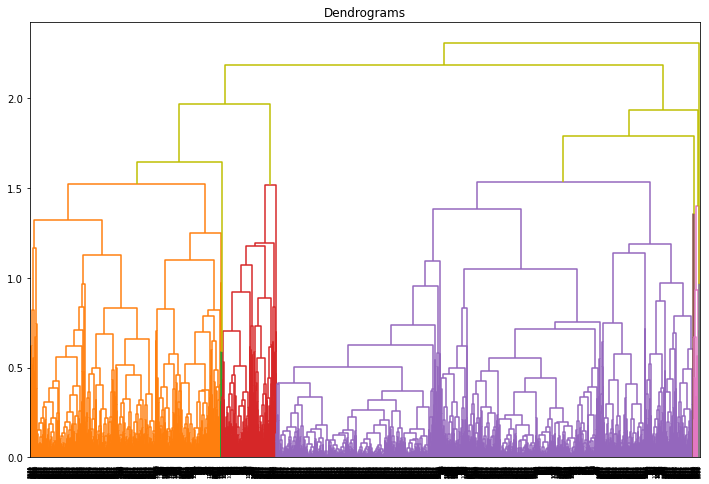

In [19]:
# drawing the dendogram (method is complete = Max (d1,d2))
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(12,8))
plt.title("Dendrograms") 

linkage= sch.linkage(df1,method='complete')

dend_complete=sch.dendrogram(linkage,orientation='top',distance_sort='descending',above_threshold_color='y')

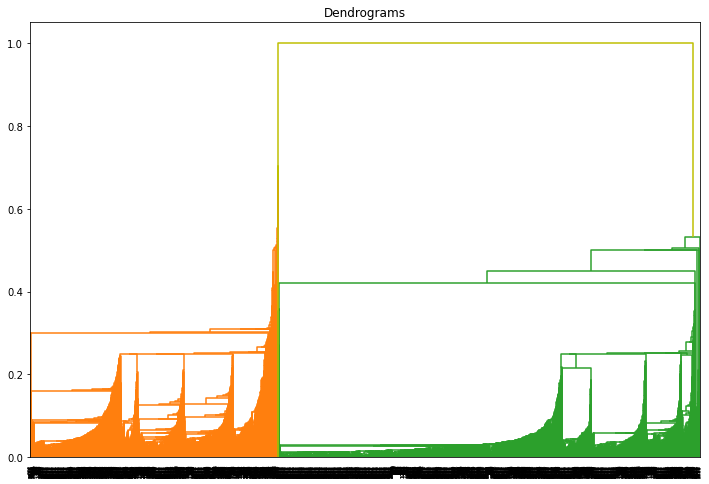

In [20]:
# drawing the dendogram (method is single = Min (d1,d2))
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(12,8))
plt.title("Dendrograms") 

linkage= sch.linkage(df1,method='single')

dend_single=sch.dendrogram(linkage,orientation='top',distance_sort='descending',above_threshold_color='y')

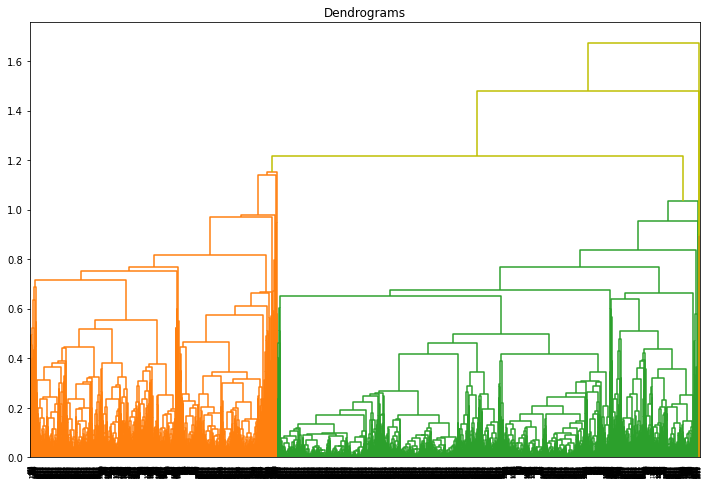

In [21]:
# drawing the dendogram (method is average = avg (d1,d2))
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(12,8))
plt.title("Dendrograms") 


linkage= sch.linkage(df1,method='average')

dend_average=sch.dendrogram(linkage,orientation='top',distance_sort='descending',above_threshold_color='y')

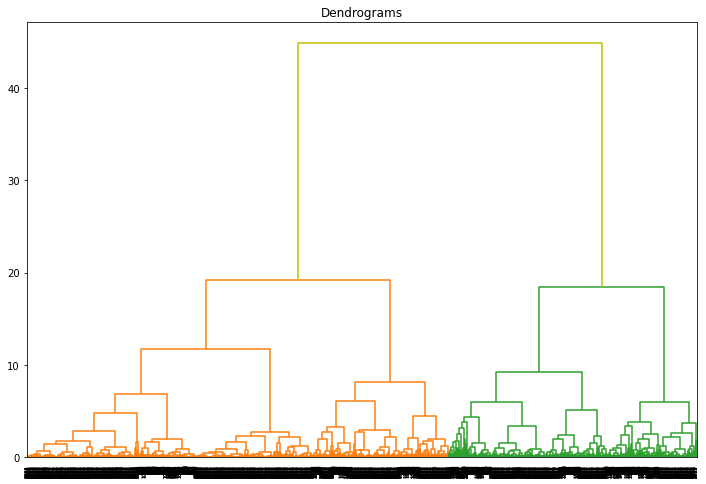

In [22]:
# drawing the dendogram (method is ward, Ward variance minimization algorithm checks variance betweeen diff clusters,
# ward=Vc1-Vc2-Vc3)

import scipy.cluster.hierarchy as sch
plt.figure(figsize=(12,8))
plt.title("Dendrograms") 

linkage= sch.linkage(df1,method='ward')

dend_ward=sch.dendrogram(linkage,orientation='top',distance_sort='descending',above_threshold_color='y')

### From the above we will use "complete","average" and "ward" & single method to in the agglomorative clustering 


number of iteratons: 14
Maximum silhouette score is 0.5318 for optimal number of cluseters 3.


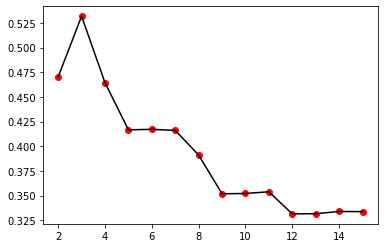

In [23]:
# linkage is complete

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

scores=[]
i=0
clt=[]



for cl in range(2,16):
    comp_cl=AgglomerativeClustering(n_clusters=cl,affinity='euclidean',linkage='complete', compute_distances=True)
    comp_cl_pred=comp_cl.fit_predict(df1)
    score=silhouette_score(df1,comp_cl_pred,metric='euclidean')
    scores.append(score)
    clt.append(cl)
    

    i=i+1
    
    if (score>=max(scores)):
        comp_cl_score=round(score,4)
        comp_cl_cluster=cl
    
    
print ("number of iteratons:", i)

print("Maximum silhouette score is {} for optimal number of cluseters {}.".format(comp_cl_score,comp_cl_cluster))


plt.plot(clt,scores,color="black")
plt.scatter(clt,scores,color="red")
plt.show() 

number of iteratons: 14
Maximum silhouette score is 0.5358 for optimal number of cluseters 2.


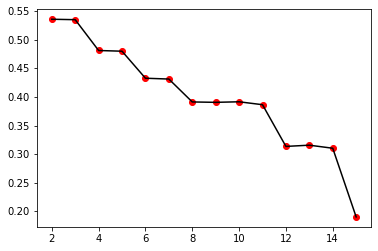

In [24]:
## linkage is single

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

scores=[]
i=0
clt=[]

for cl in range(2,16):
    single_cl=AgglomerativeClustering(n_clusters=cl,affinity='euclidean',linkage='single',compute_distances=True)
    single_cl_pred=single_cl.fit_predict(df1)
    score=silhouette_score(df1,single_cl_pred,metric='euclidean')
    scores.append(score)
    clt.append(cl)
    i=i+1
    
    
    if (score>=max(scores)):
        single_cl_score=round(score,4)
        single_cl_cluster=cl
    
    
print ("number of iteratons:", i)

print("Maximum silhouette score is {} for optimal number of cluseters {}.".format(single_cl_score,single_cl_cluster))


plt.plot(clt,scores,color="black")
plt.scatter(clt,scores,color="red")
plt.show() 


number of iteratons: 14
Maximum silhouette score is 0.5285 for optimal number of cluseters 4.


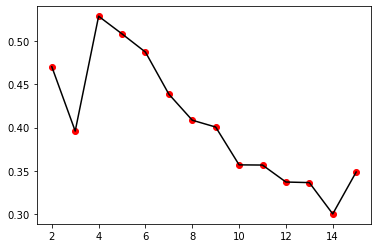

In [25]:
## linkage is average

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

scores=[]
i=0
clt=[]

for cl in range(2,16):
    average_cl=AgglomerativeClustering(n_clusters=cl,affinity='euclidean',linkage='average',compute_distances=True)
    average_cl_pred=average_cl.fit_predict(df1)
    score=silhouette_score(df1,average_cl_pred,metric='euclidean')
    scores.append(score)
    i=i+1
    clt.append(cl)
    
    if (score>=max(scores)):
        average_cl_score=round(score,4)
        average_cl_cluster=cl
    
    
print ("number of iteratons:", i)

print("Maximum silhouette score is {} for optimal number of cluseters {}.".format(average_cl_score,average_cl_cluster))


plt.plot(clt,scores,color="black")
plt.scatter(clt,scores,color="red")
plt.show() 



number of iteratons: 14
Maximum silhouette score is 0.5358 for optimal number of cluseters 2.


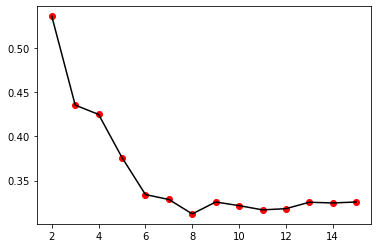

In [26]:
## linkage is ward

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

scores=[]
i=0
clt=[]

for cl in range(2,16):
    ward_cl=AgglomerativeClustering(n_clusters=cl,affinity='euclidean',linkage='ward',compute_distances=True)
    ward_cl_pred=ward_cl.fit_predict(df1)
    score=silhouette_score(df1,ward_cl_pred,metric='euclidean')
    scores.append(score)
    i=i+1
    clt.append(cl)
    
    if (score>=max(scores)):
        ward_cl_score=round(score,4)
        ward_cl_cluster=cl
    
    
print ("number of iteratons:", i)

print("Maximum silhouette score is {} for optimal number of cluseters {}.".format(ward_cl_score,ward_cl_cluster))



plt.plot(clt,scores,color="black")
plt.scatter(clt,scores,color="red")
plt.show()  
    


In [27]:
# the below tables shows number of customers in each cluster 

output1 = pd.DataFrame(data=comp_cl_pred)
output2 = pd.DataFrame(data=single_cl_pred)
output3 = pd.DataFrame(data=average_cl_pred)
output4 = pd.DataFrame(data=ward_cl_pred)

A=output1[0].value_counts(ascending=False)
B=output2[0].value_counts(ascending=False)
C=output3[0].value_counts(ascending=False)
D=output4[0].value_counts(ascending=False)

out=pd.concat([A,B,C,D], axis=1)
out.columns = ['Model A:complete', 'Model B:single', 'Model C:average', 'Model D:ward']
print(out)

    Model A:complete  Model B:single  Model C:average  Model D:ward
6                981              11              558           640
5                952               6                2           244
2                711            1451              886           310
1                556               2               17           225
3                386               2             2483           276
0                319            2488                6           116
4                 39               6                2           324
11                25               1                1           159
10                 6               9                6           115
9                  6               1                1           697
14                 4              16                2           142
13                 4               1               25           173
7                  4               1                5           346
8                  2               1            

    From the above data we can see the Model D is nicely balanced followed by Model A.However,in Model A the customer numbers changes significantly between cluster "1 & 2" where change from 750 to 4, and again between  cluster 2 & cluster 3 from 4 to 390. 
   
    The rest 2 models are skewed, we will not consider them.
    
    For best prediction we will go with the balanced model i.e Model D (Linkage is Ward) 
    
#####  we will take 2 values for Ward model ( 2 and 4 ) as sharp drop in value at clusters 2 & 4

# n_Cluster =2 

In [59]:
# fitting 2 clusters
ward_cl_2=AgglomerativeClustering(n_clusters=2, affinity = 'euclidean', linkage = 'ward')
ward_cl_2_pred=ward_cl_2.fit_predict(df1)
score_2= silhouette_score (df1, ward_cl_2_pred, metric='euclidean')

print ("Silhoutte score is:", score_2 )

# copying the dataset into a new data and add new column to capture the clusters

df_ward_2=df.copy()

df_ward_2["Clusters"]= ward_cl_2_pred

df_ward_2.head()



Silhoutte score is: 0.5358466148086706


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles,Flight_trans,enroll,Award,Clusters
0,28143,0,1,1,1,174,1,0,0,7000,0,0
1,19244,0,1,1,1,215,2,0,0,6968,0,0
2,41354,0,1,1,1,4123,4,0,0,7034,0,0
3,14776,0,1,1,1,500,1,0,0,6952,0,0
4,97752,0,4,1,1,43300,26,2077,4,6935,1,1


In [29]:
# the below tables shows number of customers in each cluster 


output4 = pd.DataFrame(data=ward_cl_2_pred)

D=output4[0].value_counts(ascending=False)

out=pd.concat([D], axis=1)
out.columns = [ 'Model D:ward']
print(out)

   Model D:ward
0          2516
1          1481


In [30]:
# group and sort by clusters 
#df_ward_2.groupby(['Clusters']).mean()

df_ward_2.groupby(['Clusters']).agg(['mean']).reset_index()

,Clusters,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles,Flight_trans,enroll,Award
,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,0,59854.586645,87.672099,1.705882,1.013911,1.008744,10235.819157,9.150238,226.472178,0.653021,3822.419714,0.0
1,1,97053.051317,240.196489,2.661715,1.015530,1.018231,28905.414585,15.782579,857.501013,2.599595,4625.062120,1.0


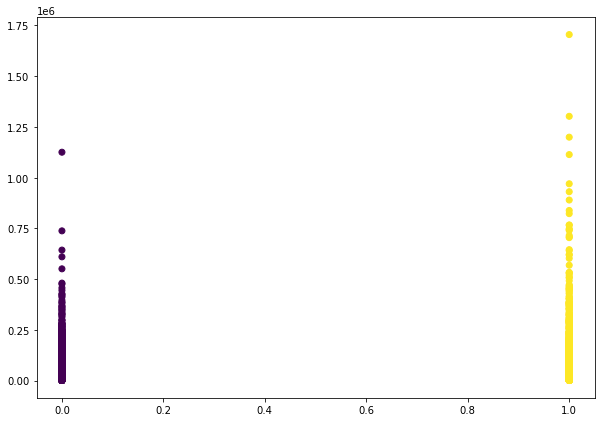

In [31]:
# Plot Clusters
plt.figure(figsize=(10, 7))  
plt.scatter(df_ward_2['Clusters'],df_ward_2['Balance'],c=ward_cl_2.labels_) 

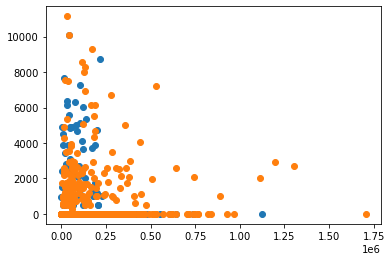

In [32]:
for i in set(ward_cl_2_pred):
    plt.scatter(df_ward_2[df_ward_2["Clusters"]==i].iloc[:,0],df_ward_2[df_ward_2["Clusters"]==i].iloc[:,1])

# n_Clusters=4

In [60]:
# fitting 4 clusters
ward_cl_4=AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
ward_cl_4_pred=ward_cl_4.fit_predict(df1)

score_4= silhouette_score (df1, ward_cl_4_pred, metric='euclidean')

print ("Silhoutte score is:", score_4 )


# copying the dataset into a new data and add new column to capture the clusters

df_ward_4=df.copy()

df_ward_4["Clusters"]= ward_cl_4_pred

df_ward_4.head()

Silhoutte score is: 0.42484070340085706


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles,Flight_trans,enroll,Award,Clusters
0,28143,0,1,1,1,174,1,0,0,7000,0,0
1,19244,0,1,1,1,215,2,0,0,6968,0,0
2,41354,0,1,1,1,4123,4,0,0,7034,0,0
3,14776,0,1,1,1,500,1,0,0,6952,0,0
4,97752,0,4,1,1,43300,26,2077,4,6935,1,3


In [34]:
# the below tables shows number of customers in each cluster 


output4 = pd.DataFrame(data=ward_cl_4_pred)

D=output4[0].value_counts(ascending=False)

out=pd.concat([D], axis=1)
out.columns = [ 'Model D:ward']
print(out)

   Model D:ward
0          1708
1           946
2           808
3           535


In [35]:
# group and sort by clusters 
df_ward_4.groupby(['Clusters']).agg(['mean']).reset_index()



,Clusters,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles,Flight_trans,enroll,Award
,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,0,37920.071429,52.858899,1.000000,1.019906,1.000585,2561.504098,5.737705,239.594262,0.697892,3564.677986,0.0
1,1,79848.233615,285.097252,1.699789,1.024313,1.000000,12079.774841,12.133192,781.939746,2.369979,4372.173362,1.0
2,2,106221.111386,161.262376,3.198020,1.001238,1.025990,26458.257426,16.363861,198.733911,0.558168,4367.250000,0.0
3,3,127475.028037,160.801869,4.362617,1.000000,1.050467,58656.919626,22.235514,991.110280,3.005607,5072.226168,1.0


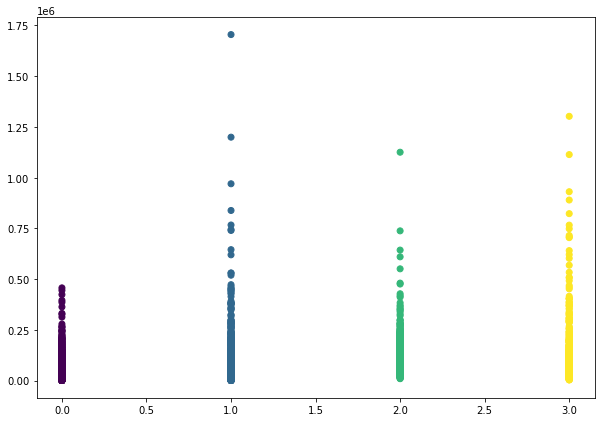

In [36]:
# Plot Clusters
plt.figure(figsize=(10, 7))  
plt.scatter(df_ward_4['Clusters'],df_ward_4['Balance'],c=ward_cl_4.labels_) 

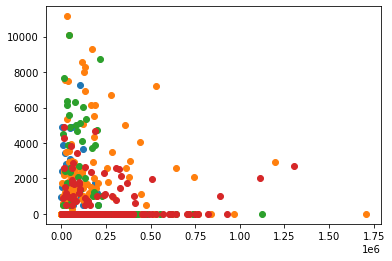

In [37]:
for i in set(ward_cl_4_pred):
    plt.scatter(df_ward_4[df_ward_4["Clusters"]==i].iloc[:,0],df_ward_4[df_ward_4["Clusters"]==i].iloc[:,1])

# K-Means Clustering

In [38]:
from sklearn.cluster import KMeans


# Finding optimal number of clusters
iner = []
for cl in range(1, 12):
    kmeans = KMeans(n_clusters=cl,random_state=0)
    kmeans.fit(df1)
    iner.append(kmeans.inertia_)
    


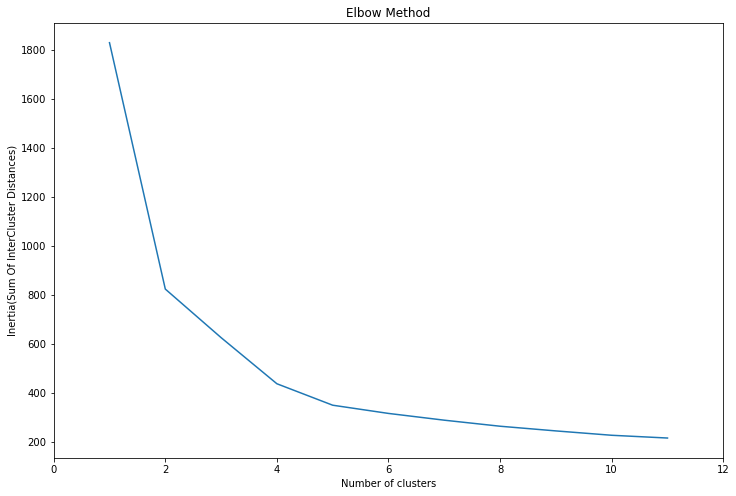

In [39]:
#plotting the graph
plt.figure(figsize=(12,8))    
plt.plot(range(1, 12), iner)
plt.title('Elbow Method')
plt.xlim(0,12)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia(Sum Of InterCluster Distances)')
plt.show()

##### we will use n_cluster =2 as we can see there is a sharp decline of  values as point 2
##### lets prove if optimal cluster is 2 using code

In [40]:
# iterating through various cluster

scores=[]
km_score=0
km_cluster=0
i=0
for cl in range(2,8):
    km= KMeans(n_clusters=cl, random_state=0)
    km_pred = km.fit_predict(df1)
    score= silhouette_score (df1, km_pred, metric='euclidean')
    scores.append(score)
    i=i+1
    if (score>=max(scores)):
        km_score=round(score,3)
        km_cluster=cl

print("Number of iterations:",i)
print("Maximum silhouette score is {} for optimal number of clusters-{}.".format(km_score,km_cluster))


Number of iterations: 6
Maximum silhouette score is 0.536 for optimal number of clusters-2.


For n_clusters = 2 The average silhouette_score is : 0.5358466148086706
For n_clusters = 3 The average silhouette_score is : 0.4647544320834145
For n_clusters = 4 The average silhouette_score is : 0.4747529764917658
For n_clusters = 5 The average silhouette_score is : 0.442890405520313
For n_clusters = 6 The average silhouette_score is : 0.4021559597204469
For n_clusters = 7 The average silhouette_score is : 0.39015278841056283


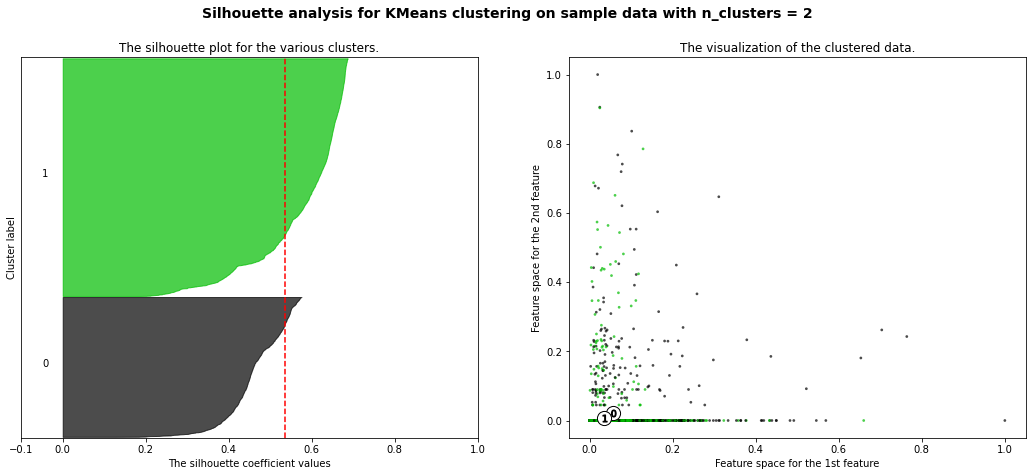

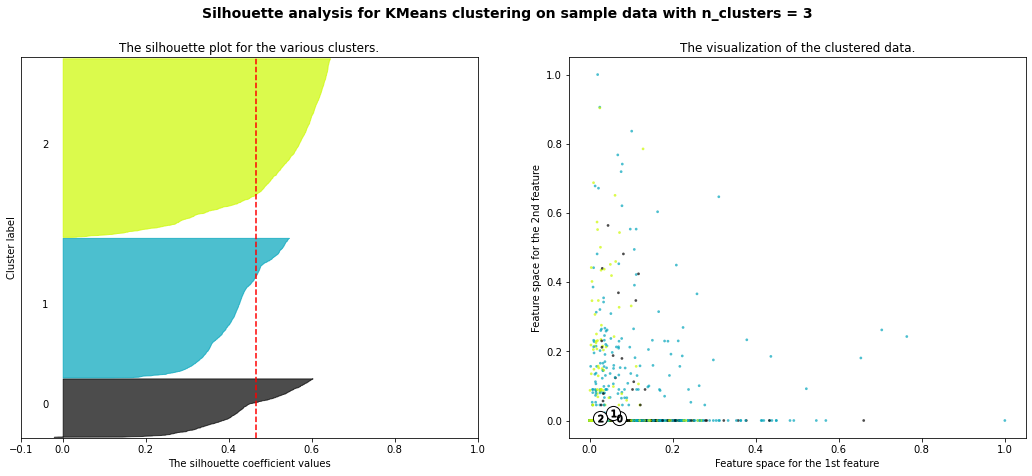

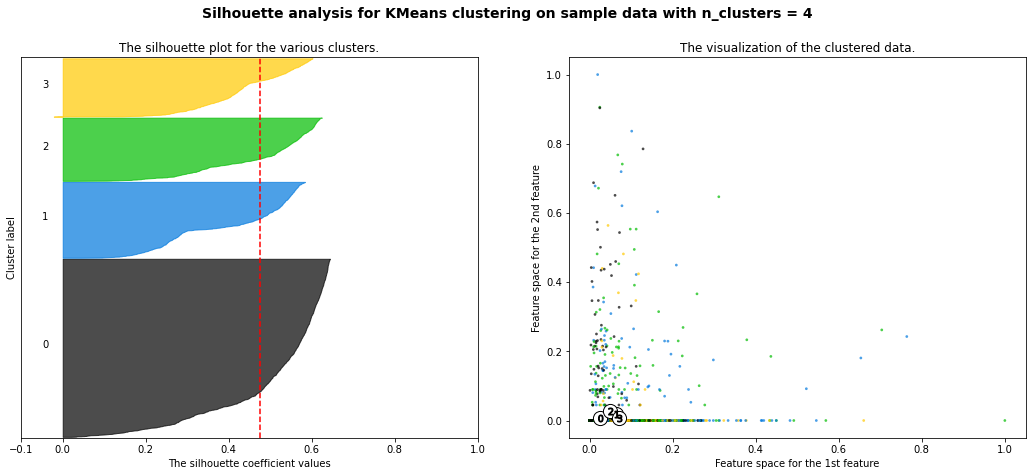

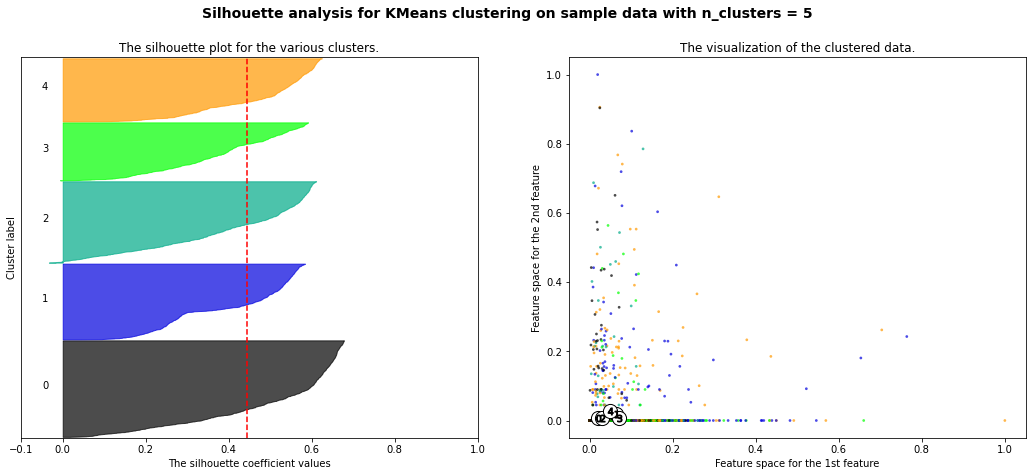

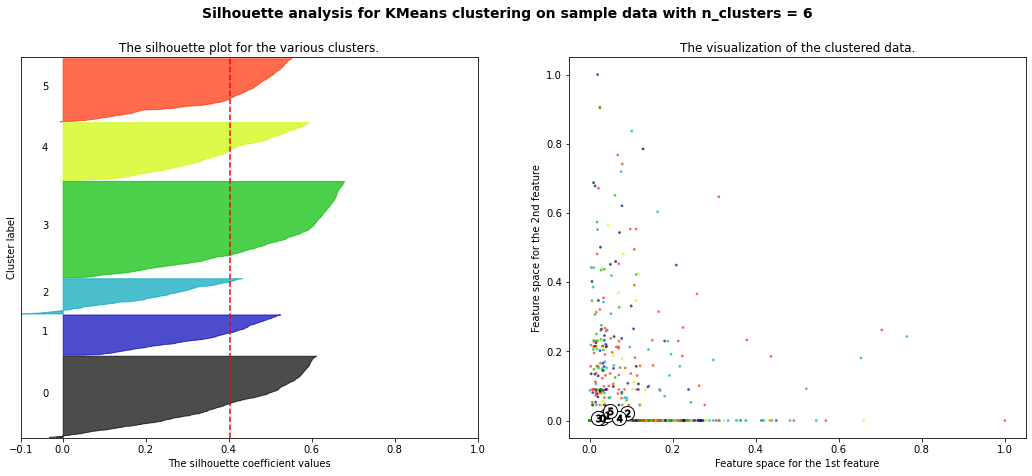

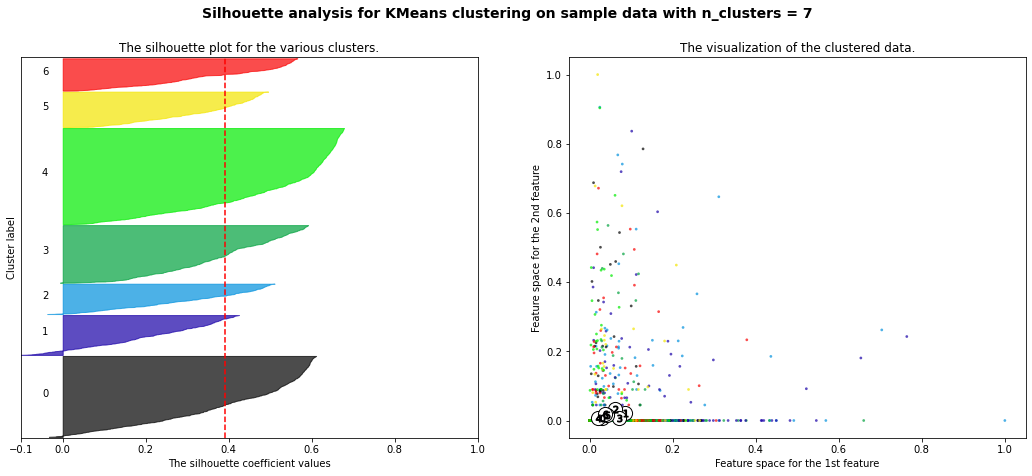

In [41]:
for n_clusters in range(2,8):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df1) + (n_clusters + 1) * 10]) # change

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df1) # Change

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df1, cluster_labels) # change
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df1, cluster_labels) # change

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df1.iloc[:, 0], df1.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#### From the above Cluster 2 doesn't have any - ve values so we will go with Clusters =2

In [42]:
# checking Silhoutte score
km= KMeans(n_clusters=2, random_state=0)
km_pred = km.fit_predict(df1)
score= silhouette_score (df1, km_pred, metric='euclidean')


print("Maximum silhouette score is {} for optimal number of clusters 2.".format(score))

Maximum silhouette score is 0.5358466148086706 for optimal number of clusters 2.


In [43]:
df_km=df.copy()

df_km["Clusters"]= km_pred

df_km.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles,Flight_trans,enroll,Award,Clusters
0,28143,0,1,1,1,174,1,0,0,7000,0,1
1,19244,0,1,1,1,215,2,0,0,6968,0,1
2,41354,0,1,1,1,4123,4,0,0,7034,0,1
3,14776,0,1,1,1,500,1,0,0,6952,0,1
4,97752,0,4,1,1,43300,26,2077,4,6935,1,0


In [44]:
# the below tables shows number of customers in each cluster 


output = pd.DataFrame(data=km_pred)

D=output[0].value_counts(ascending=False)

out=pd.concat([D], axis=1)
out.columns = [ 'K means']
print(out)

   K means
1     2516
0     1481


In [45]:
# group and sort by clusters 
df_km.groupby(['Clusters']).agg(['mean']).reset_index()

,Clusters,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles,Flight_trans,enroll,Award
,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,0,97053.051317,240.196489,2.661715,1.015530,1.018231,28905.414585,15.782579,857.501013,2.599595,4625.062120,1.0
1,1,59854.586645,87.672099,1.705882,1.013911,1.008744,10235.819157,9.150238,226.472178,0.653021,3822.419714,0.0


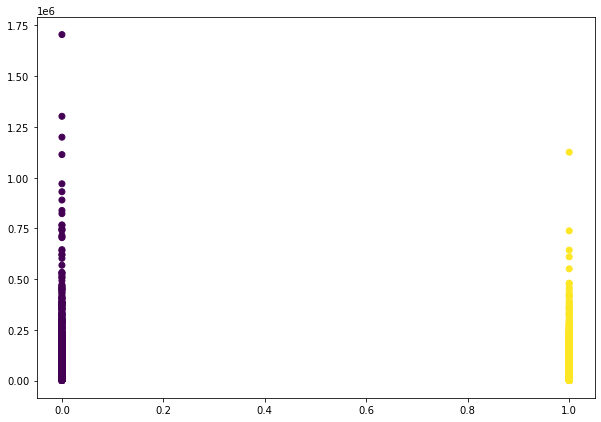

In [46]:
# Plot Clusters
plt.figure(figsize=(10, 7))  
plt.scatter(df_km['Clusters'],df_km['Balance'],c=km.labels_) 

# DBscan clustering

### For DBSCAN clustering we will need 
#### i) ( min point)

    For dataset more than 2 Dimension , choose MinPts = 2*dim ( dim = dimenson of the data set).
    In this case we will start from 20 to a range of 52 with a incremental of 4 

#### ii) Epsilon 
    I have selected 20 as my minpoint , so going to alculate the average distance between each point in the data set and its 20 nearest neighbors 




In [47]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(df1)
distances, indices = neighbors_fit.kneighbors(df1)

In [48]:
distances[0:5],distances.shape

(array([[0.        , 0.00871531, 0.00982329, 0.01139457, 0.01277601,
         0.01331785, 0.01445224, 0.01522595, 0.0169149 , 0.0190791 ,
         0.02126834, 0.02209439, 0.02239988, 0.02272177, 0.02272459,
         0.02337595, 0.02411791, 0.025343  , 0.02845814, 0.02932871],
        [0.        , 0.01212297, 0.01331785, 0.01483947, 0.01590046,
         0.01979155, 0.0200706 , 0.02066999, 0.02338798, 0.02353866,
         0.02424792, 0.02439492, 0.02503437, 0.02696982, 0.02751054,
         0.0288704 , 0.03149609, 0.03166029, 0.03171017, 0.03473729],
        [0.        , 0.01857767, 0.01872551, 0.01892042, 0.02504777,
         0.02735412, 0.03149609, 0.03254401, 0.03579654, 0.03660932,
         0.03693779, 0.03716255, 0.0389617 , 0.04076305, 0.04179049,
         0.04185845, 0.04240907, 0.04293356, 0.04531016, 0.04552297],
        [0.        , 0.00982329, 0.01107883, 0.01188223, 0.01203399,
         0.01212297, 0.01284137, 0.01285681, 0.01463585, 0.01608839,
         0.01686919, 0.02122161

In [49]:
indices

array([[   0,  363,    3, ...,  368,  502,  299],
       [   1,    3,    0, ...,  502,  358,  331],
       [   2,  338,  344, ...,  316,  278,   84],
       ...,
       [3994, 3875, 3829, ..., 2791, 3929, 3687],
       [3995, 3968, 3966, ..., 3973, 3916, 3910],
       [3996, 3490, 3454, ..., 3910, 3908, 3368]])

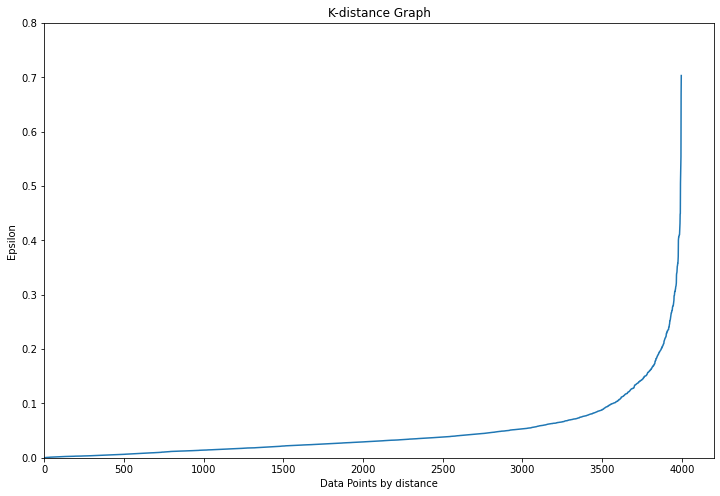

In [50]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
dist = distances[:,1]

plt.figure(figsize=(12,8))
plt.plot(dist)

plt.title('K-distance Graph',fontsize=12)
plt.xlabel('Data Points by distance',fontsize=10)
plt.xlim(0,4200)
plt.ylim(0,.8)
plt.ylabel('Epsilon',fontsize=10)
plt.show()

    The ideal value for ε will be equal to the distance value at the “crook of the elbow”, or the point of maximum curvature.

  

In [69]:
from sklearn.cluster import DBSCAN

scores=[]


i=0

for s in range(20,52,4):
    for e in np.arange(0.15,0.7,0.05):
        db=DBSCAN(eps=e,min_samples=s)
        db.fit(df1)
        db_pred=db.fit_predict(df1)
        score= silhouette_score (df1, db_pred, metric='euclidean')
        scores.append(score)
        i=i+1
        
        if(score>=max(scores)):
            
            db_score=round(score,3)
            eps=round(e,3)
            samp=s

print("Number of iterations:",i)            

print("Maximum silhouette score is {} for minimum number of samples: {} and epsilon value : {}.".format(db_score,samp,eps))




Number of iterations: 88
Maximum silhouette score is 0.535 for minimum number of samples: 40 and epsilon value : 0.65.


In [63]:
db=DBSCAN(eps=0.65,min_samples=40)
db.fit(df1)
db_pred=db.fit_predict(df1)

In [64]:
db_df=df.copy()
db_df['Clusters']=db_pred
db_df.head(15)

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles,Flight_trans,enroll,Award,Clusters
0,28143,0,1,1,1,174,1,0,0,7000,0,0
1,19244,0,1,1,1,215,2,0,0,6968,0,0
2,41354,0,1,1,1,4123,4,0,0,7034,0,0
3,14776,0,1,1,1,500,1,0,0,6952,0,0
4,97752,0,4,1,1,43300,26,2077,4,6935,1,1
5,16420,0,1,1,1,0,0,0,0,6942,0,0
6,84914,0,3,1,1,27482,25,0,0,6994,0,0
7,20856,0,1,1,1,5250,4,250,1,6938,1,1
8,443003,0,3,2,1,1753,43,3850,12,6948,1,1
9,104860,0,3,1,1,28426,28,1150,3,6931,1,1


In [65]:
# Using groupby function to sort by Clusters
db_df.groupby(['Clusters']).mean()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles,Flight_trans,enroll,Award
Clusters,,,,,,,,,,,
-1,73034.833333,83.333333,1.833333,1.000000,3.500000,122269.666667,25.333333,5239.833333,9.333333,2854.666667,0.666667
0,59844.279236,87.741846,1.706444,1.013922,1.005967,10191.509944,9.149165,226.652347,0.653540,3823.707239,0.000000
1,97117.794177,240.508463,2.662830,1.015572,1.012864,28576.280298,15.736628,838.537576,2.568720,4628.975626,1.000000


In [66]:
# the below tables shows number of customers in each cluster 


output = pd.DataFrame(data=db_pred)

D=output[0].value_counts(ascending=False)

out=pd.concat([D], axis=1)
out.columns = [ 'DBSCAN']
print(out)

    DBSCAN
 0    2514
 1    1477
-1       6


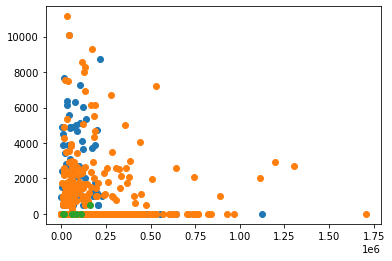

In [67]:
for i in set(db_pred):
    plt.scatter(db_df[db_df["Clusters"]==i].iloc[:,0],db_df[db_df["Clusters"]==i].iloc[:,1])

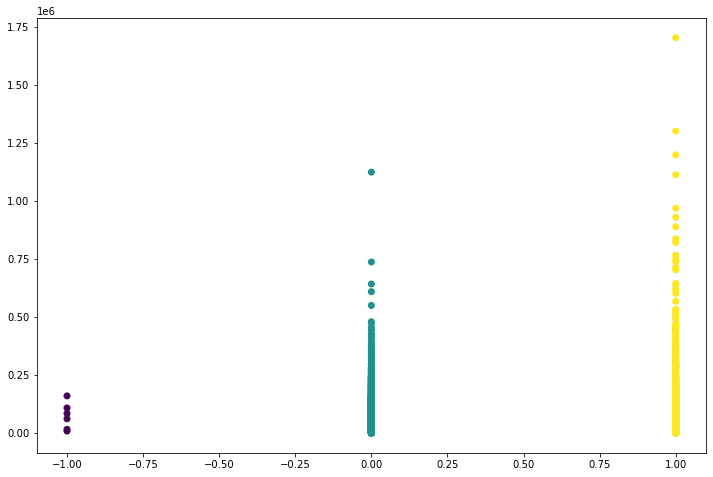

In [70]:
# Plot Clusters
plt.figure(figsize=(12, 8))  
plt.scatter(db_df['Clusters'],db_df['Balance'],c=db.labels_) 

# Results

In [71]:
results={'Clustering':['Hierarchical clustering','K-Means clustering','DBSCAN'],
   'Silhouette score':[ward_cl_score,km_score,db_score],
   'Clusters predicted':[ward_cl_cluster,km_cluster,3]}
clusters=pd.DataFrame(results)
clusters

,Clustering,Silhouette score,Clusters predicted
0,Hierarchical clustering,0.5358,2
1,K-Means clustering,0.5360,2
2,DBSCAN,0.5350,3


### It can be seen that the silhoutte score is almost similar between all the three cluster with normalized data. We can use any one of the above method clustering for our purpose.

